In [1]:
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.feature_selection import mutual_info_classif


In [15]:
def split_labels(df, cols):
    '''split the dataframe into predicting table and labels
       df: given dataset
       cols: list of labels
    '''
    return df[[i for i in df if i not in cols]], df[cols]


def Logistic(X_train,y_train, X_test):
    clf = LogisticRegression(max_iter=10000, penalty='l1', C=1.6, solver= 'liblinear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    return y_pred

   
def CART(X_train,y_train, X_test):
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def one_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test 

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)
    
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    return accuracy, macro_sensitivity, macro_specificity

def predict(X,Y, predictors):
    X_train, X_test, y_train, y_test = one_split(X, Y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    pred_Y = [pred(X_train,y_train, X_test) for pred in predictors]
    return [get_classification_metrics(y_test, p) for p in pred_Y]

def PCA_model(X, n = 2):
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

def SE_rbf(X, n=2):
    sigma = 0.1
    se = SpectralEmbedding(n_components=n, affinity='rbf', n_neighbors=30, gamma=1 / (2 * sigma ** 2))
    X_CE = se.fit_transform(X)
    return X_CE

def SE_nn(X, n=2):
    se = SpectralEmbedding(n_components=n, affinity='nearest_neighbors', n_neighbors=30, eigen_solver='arpack')
    X_CE = se.fit_transform(X)
    return X_CE

# -------------------------------------------------------------------
predictors = [CART, Logistic]
predictorsTXT = ['CART', 'Logistic']
# -------------------------------------------------------------------
DR = [ PCA_model, SE_rbf, SE_nn]
DR_TXT = [ 'PCA_model','SE_rbf', 'SE_nn']

# Dataset2

In [16]:
df2 = pd.read_excel('CTG.xls', sheet_name = 'Raw Data')

df2 = df2[[i for i in df2 if i not in ["FileName","Date","SegFile","b","e","CLASS"]]]
print(df2.shape)

df2 = df2.dropna()
X2, Y2 = split_labels(df2, ['NSP'])
X2.head()
# X2 = stats.zscore(X2)
# X2

(2126, 34)


,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,A,B,C,D,E,AD,DE,LD,FS,SUSP
0,120,120,0,0,0,73,0.5,43,2.4,0,...,0,0,0,0,0,0,0,0,1,0
1,132,132,4,0,4,17,2.1,0,10.4,2,...,0,0,0,0,0,1,0,0,0,0
2,133,133,2,0,5,16,2.1,0,13.4,2,...,0,0,0,0,0,1,0,0,0,0
3,134,134,2,0,6,16,2.4,0,23.0,2,...,0,0,0,0,0,1,0,0,0,0
4,132,132,4,0,5,16,2.4,0,19.9,0,...,0,1,0,0,0,0,0,0,0,0


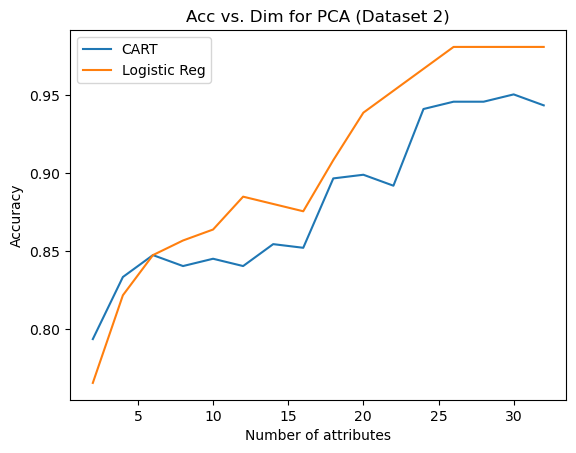

In [17]:
# Doing PCA...
All = {}
for NoF in range (2, X2.shape[1], 2): # Number of features
    X2s = PCA_model(X2, NoF) # dimension reduction
    results1 = predict(X2s, np.ravel(Y2), predictors) # Machine learning models
    
    All[NoF] = [results1[0][0], results1[1][0]]

num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic Reg': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic Reg'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for PCA (Dataset 2)")
plt.show()

In [20]:
df2 = pd.read_excel('CTG.xls', sheet_name = 'Raw Data')

df2 = df2[[i for i in df2 if i not in ["FileName","Date","SegFile","b","e","CLASS"]]]
print(df2.shape)

df2 = df2.dropna()
X2, Y2 = split_labels(df2, ['NSP'])

All = {}
print(X2.shape[1])
X_train, X_test, y_train, y_test = one_split(X2, Y2)
SE = SE_nn

for NoF in range (2, X2.shape[1]-1,3): # Number of features
    X_train_SE = SE(X_train, NoF)
    
    X_test_SE = pd.DataFrame(columns=[i for i in range(NoF)])
    
    for _, row in X_test.iterrows():
        X_tr = X_train.copy()
        X_tr.loc[len(X_tr)] = row        
        X_tr_SE = SE(X_tr, NoF)        
        rbf = X_tr_SE[-1]
        X_test_SE.loc[len(X_test_SE)] = rbf
    
    scaler = StandardScaler()
    X_train_SE = scaler.fit_transform(X_train_SE)
    
    X_test_SE = scaler.transform(X_test_SE)
    
    pred_Y = [pred(X_train_SE,  np.ravel(y_train), X_test_SE) for pred in predictors]
    results = [get_classification_metrics(y_test, p) for p in pred_Y]

    All[NoF] = [results[0][0], results[1][0]]
    print(NoF, results[0][0], results[1][0])    


(2126, 34)
33
2 0.7652582159624414 0.7652582159624414
5 0.7652582159624414 0.7652582159624414
8 0.7652582159624414 0.7652582159624414
11 0.7652582159624414 0.7652582159624414
14 0.7652582159624414 0.7652582159624414
17 0.7652582159624414 0.755868544600939
20 0.7652582159624414 0.7511737089201878
23 0.7652582159624414 0.744131455399061
26 0.7652582159624414 0.6995305164319249
29 0.7652582159624414 0.715962441314554


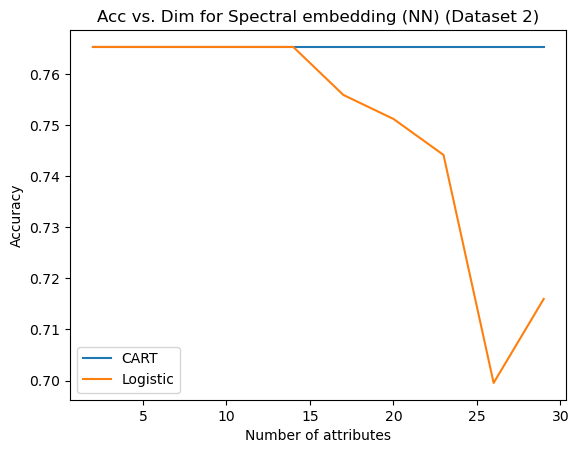

In [21]:
num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for Spectral embedding (NN) (Dataset 2)")
plt.show()

## Popular TECHNIQUE
- convert the entire dataset into embedding representation...

In [11]:
df2 = pd.read_excel('CTG.xls', sheet_name = 'Raw Data')

df2 = df2[[i for i in df2 if i not in ["FileName","Date","SegFile","b","e","CLASS"]]]
print(df2.shape)

df2 = df2.dropna()
X2, Y2 = split_labels(df2, ['NSP'])

(2126, 34)


In [12]:
All = {}
print(X2.shape[1])
X_embedded = SE_nn(X2)
X_train, X_test, y_train, y_test = one_split(X_embedded, Y2)

for NoF in range (2, X2.shape[1]-1,2): # Number of features
    print(f'simulation number {NoF}')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    X_test  = scaler.transform(X_test)
    
    pred_Y = [pred(X_train, np.ravel(y_train), X_test) for pred in predictors]
    results = [get_classification_metrics(y_test, p) for p in pred_Y]

    All[NoF] = [results[0][0], results[1][0]]
print('Spectral embedding nn')
All   


33
simulation number 2
simulation number 4
simulation number 6
simulation number 8
simulation number 10
simulation number 12
simulation number 14
simulation number 16
simulation number 18
simulation number 20
simulation number 22
simulation number 24
simulation number 26
simulation number 28
simulation number 30
Spectral embedding nn


{2: [0.7978056426332288, 0.7821316614420063],
 4: [0.799373040752351, 0.7821316614420063],
 6: [0.7978056426332288, 0.7821316614420063],
 8: [0.799373040752351, 0.7821316614420063],
 10: [0.7978056426332288, 0.7821316614420063],
 12: [0.7978056426332288, 0.7821316614420063],
 14: [0.799373040752351, 0.7821316614420063],
 16: [0.7978056426332288, 0.7821316614420063],
 18: [0.7978056426332288, 0.7821316614420063],
 20: [0.7978056426332288, 0.7821316614420063],
 22: [0.7978056426332288, 0.7821316614420063],
 24: [0.7978056426332288, 0.7821316614420063],
 26: [0.799373040752351, 0.7821316614420063],
 28: [0.799373040752351, 0.7821316614420063],
 30: [0.799373040752351, 0.7821316614420063]}

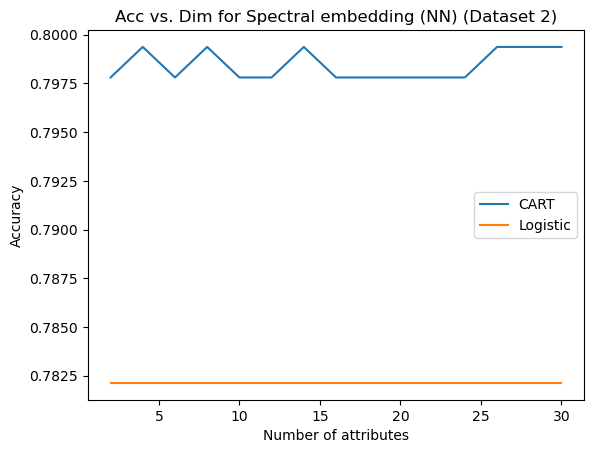

In [13]:
num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for Spectral embedding (NN) (Dataset 2)")
plt.show()